In [1]:
"""----------------------------------------
Author: Rajkumar Conjeevaram Mohan
Imperial College London Graduate
Program: Gaussian Process
-----------------------------------------"""

'----------------------------------------\nAuthor: Rajkumar Conjeevaram Mohan\nImperial College London Graduate\nProgram: Gaussian Process\n-----------------------------------------'

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import ipdb
from sklearn.gaussian_process.kernels import Matern

In [61]:
# Define the kernel
def rbf_kernel(a, b, kernelParameter=0.1, sigma_f=1.0, p=0):
    """ Squared exponential kernel """
    # length parameter = kernelParameter
    sqdist = np.sum(a**2, axis=1).reshape([-1, 1]) + \
             np.sum(b**2, axis=1) - \
             2*np.dot(a, b.T)
    return sigma_f * np.exp(-.5 * (1/kernelParameter**2) * sqdist)

def rbf_delta(a, b, kernelParameter=0.1):
    """ Squared exponential kernel """
    # length parameter = kernelParameter
    sqdist = np.sum(a**2, axis=1).reshape([-1, 1]) + \
             np.sum(b**2, axis=1) - \
             2*np.dot(a, b.T)
    return -.5 * (1/kernelParameter**3) * sqdist

def periodic_kernel(a, b, kernelParameter=0.1, sigma_f=1.0, p=3.55):
    dist = np.sum(a, axis=1).reshape([-1, 1]) - \
           np.sum(b, axis=1)
    return sigma_f * np.exp(((-2 * np.sin(np.pi * dist)**2)/p)/kernelParameter)

def matern_kernel(a, b, kernelParameter=0.1, sigma_f=1.0, p=0):
    #     dist = np.sum(a**2, axis=1).reshape([-1, 1]) + \
    #            np.sum(b**2, axis=1) - \
    #            2*np.dot(a, b.T)
    #     dist = np.linalg.cholesky(dist + np.eye(dist.shape[0]) * 1e-5)
    #     K = sigma_f*(1 + (np.sqrt(3) * dist)/l) * np.exp(- (np.sqrt(3) * dist)/l)
    matern = Matern(length_scale=kernelParameter, nu=sigma_f)
    return matern(a, b)

In [48]:
N = 15         # number of training points.
n = 40         # number of test points.
s = 0.00006    # noise variance.
# s = 1e-2

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = list(np.linspace(-5, 2, N))
X.append(2)
X = np.reshape(X, [-1, 1])
Xs = np.linspace(-3, 5, n).reshape([-1, 1])
y = np.sin(X) + s*np.random.randn(N+1).reshape([-1, 1])

In [49]:
tmp_l = list(np.linspace(0, 1, 2))
tmp_l.append(4)
print(tmp_l)

[0.0, 1.0, 4]


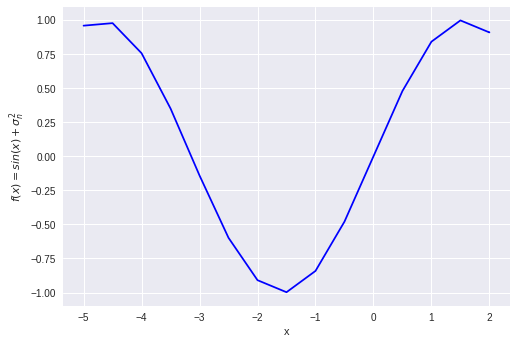

In [50]:
plt.style.use('seaborn')
plt.figure()
plt.xlabel('x')
plt.ylabel('$f(x)=sin(x)+\sigma_n^2$')
plt.plot(X, y, '-b')
plt.show()

In [51]:
K = rbf_kernel(X, X, kernelParameter=0.6)
mu = np.zeros([N+1, 1])
# sample functions from prior distribution
samples = np.random.multivariate_normal(mu.ravel(), K, 6)

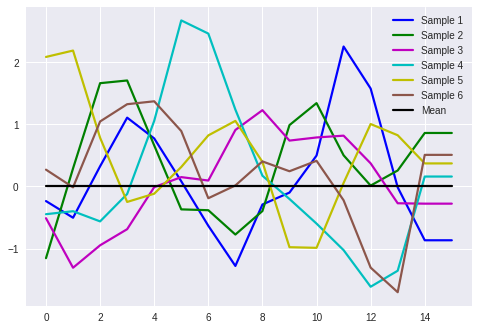

In [52]:
plt.figure()
plt.plot(samples[0], '-b', label='Sample 1', linewidth=2.2)
plt.plot(samples[1], '-g', label='Sample 2', linewidth=2.2)
plt.plot(samples[2], '-m', label='Sample 3', linewidth=2.2)
plt.plot(samples[3], '-c', label='Sample 4', linewidth=2.2)
plt.plot(samples[4], '-y', label='Sample 5', linewidth=2.2)
plt.plot(samples[5], 'tab:brown', label='Sample 6', linewidth=2.2)
plt.plot(mu.ravel(), '-k', label='Mean', linewidth=2.2)
plt.legend()
plt.show()

In [53]:
def posterior_predictive(kernel, X_test, X_train, Y_train, kernel_param, sigma_f, p=0):
    """
    Computes the parameters for GP posterior predictive distribution
    """
    
    # s is the amount of noise
    K = kernel(X_train, X_train, kernel_param, sigma_f=sigma_f, p=p) + np.eye(X_train.shape[0]) * s
    K_s = kernel(X_train, X_test, kernel_param, sigma_f=sigma_f, p=p)
    K_ss = kernel(X_test, X_test, kernel_param, sigma_f=sigma_f, p=p) #+ 1e-6 * np.eye(X_test.shape[0])
    K_inv = np.linalg.inv(K)
    
#     m_X = (np.eye(K.shape[0]) + (K @ (1/s * np.eye(K.shape[0])))) @ y # s noise variance
    m_n = K_s.T @ K_inv @ (Y_train - 0) # where m_X is the posterior mean
    S_n = K_ss - K_s.T @ K_inv @ K_s
    
    return m_n, S_n

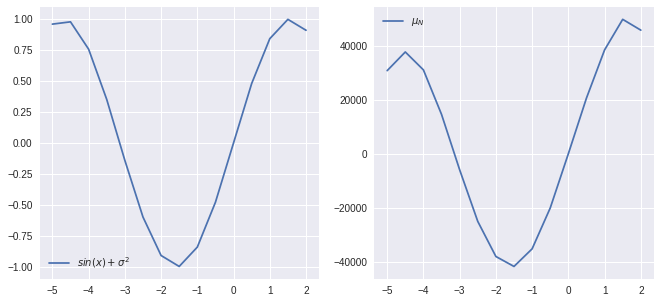

In [54]:
m_X = (np.eye(K.shape[0]) + (K @ (1/s * np.eye(K.shape[0])))) @ y
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
axes[0].plot(X.ravel(), y.ravel(), label='$sin(x)+\sigma^2$')
axes[0].legend()
axes[1].plot(X.ravel(), m_X.ravel(), label='$\mu_N$')
axes[1].legend()
plt.show()

In [55]:
def mse(y, y_hat):
    return np.mean((y - y_hat)**2, axis=0)

In [103]:
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

indices = (X[:, 0] >= -3) & (X[:, 0] <=2 )
X_filtered = X[indices, 0]
y_filtered = y[indices, 0]
alpha_98 = 2.457
alpha_95 = 2.042

# layout = {'width':'90%', 'height': '80px', 'border': 'solid', 'readout_color': 'red'}
# style = {'handle_color': 'silver'}
@interact(kernel_param=FloatSlider(min=0.1, max=10.0, step=0.1, value=2.2984389960067766, continuous_update=True),#, layout=layout, style=style),
          sigma_f=FloatSlider(min=0.1, max=3.0, step=0.1, value=0.9266234864974641, continuous_update=True))#, layout=layout, style=style))
def plot_gp(kernel_param, sigma_f):
    m_n, S_n = posterior_predictive(rbf_kernel, Xs, X, y, kernel_param, sigma_f)
    post_std = np.sqrt(np.diag(S_n))
    posterior_samples = np.random.multivariate_normal(m_n.ravel(), S_n, 6)

    plt.figure()
    plt.plot(Xs.ravel(), posterior_samples[0], '-b', label='Sample 1', linewidth=2.2)
    plt.plot(Xs.ravel(), posterior_samples[1], '-g', label='Sample 2', linewidth=2.2)
    plt.plot(Xs.ravel(), posterior_samples[2], '-m', label='Sample 3', linewidth=2.2)
    plt.plot(Xs.ravel(), posterior_samples[3], '-c', label='Sample 4', linewidth=2.2)
    plt.plot(Xs.ravel(), posterior_samples[4], '-y', label='Sample 5', linewidth=2.2)
    plt.plot(Xs.ravel(), posterior_samples[5], 'tab:brown', label='Sample 6', linewidth=2.2)
    plt.plot(Xs.ravel(), m_n.ravel(), '-p', label='Mean', linewidth=2.2)
    plt.scatter(X_filtered.ravel(), y_filtered.ravel(), marker='o', c='k', zorder=10, s=90, label='Training Data')
    lower_bound_98 = m_n.ravel() - alpha_98 * post_std/np.sqrt(n)
    upper_bound_98 = m_n.ravel() + alpha_98 * post_std/np.sqrt(n)
    plt.fill_between(Xs.ravel(), lower_bound_98, upper_bound_98, alpha=0.5, color='k', label='98% Confidence Bounds')
    lower_bound_95 = m_n.ravel() - alpha_95 * post_std/np.sqrt(n)
    upper_bound_95 = m_n.ravel() + alpha_95 * post_std/np.sqrt(n)
    plt.plot(Xs.ravel(), lower_bound_95, '--k', linewidth=1.5, label='95% Confidence Bounds')
    plt.plot(Xs.ravel(), upper_bound_95, '--k', linewidth=1.5)
    plt.legend()
    plt.show()
    print("MSE %.3f" % mse(m_n.ravel(), np.sin(Xs.ravel())))

interactive(children=(FloatSlider(value=2.2984389960067766, description='kernel_param', max=10.0, min=0.1), Fl…

In [57]:
@interact(kernel_param=FloatSlider(min=0.1, max=10.0, step=0.1, value=2.7, continuous_update=True),#, layout=layout, style=style),
          sigma_f=FloatSlider(min=0.1, max=10.0, step=0.1, continuous_update=True))
def playground(kernel_param, sigma_f):
    m_n, S_n = posterior_predictive(rbf_kernel, Xs, X, y, kernel_param, sigma_f)
    plt.figure()
    plt.plot(Xs.ravel(), m_n.ravel(), '-r', label='Predicted')
    tmp_ys = np.sin(Xs)
    plt.plot(Xs.ravel(), tmp_ys, '-b', label='Actual')
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=2.7, description='kernel_param', max=10.0, min=0.1), FloatSlider(value…

In [98]:
def train_GP(kernelParameter=1, sigma_f=1):
    epochs = 400
    best_loss = np.inf
    best_l = None
    best_sigma_f = None
    for epoch in range(epochs):
        K = rbf_kernel(X, X, kernelParameter, sigma_f=sigma_f) + np.eye(X.shape[0]) * s
        K_inv = np.linalg.inv(K + np.eye(K.shape[0]) * sigma_f)
        alpha = K_inv @ y
        sqdist1 = np.sum(X**2, axis=1).reshape([-1, 1]) + \
                  np.sum(X**2, axis=1) - \
                  2*np.dot(X, X.T)
        sqdist2 = np.exp(-.5 * (1/kernelParameter) * sqdist1)
        sigma_f_delta = -0.5 * np.trace((alpha @ alpha.T - K_inv) @ sqdist2)
        l_delta = 0.5 * np.trace((alpha @ alpha.T - K_inv) @ \
                                  rbf_delta(X, X, kernelParameter))
        sigma_f -= 1e-3 * sigma_f_delta
        kernelParameter -= 5e-3 * l_delta
        m_n, _ = posterior_predictive(rbf_kernel, Xs, X, y, kernelParameter, sigma_f)
        loss = mse(m_n.ravel(), np.sin(Xs.ravel()))
        print("Epoch: %d, Loss: %.3f" % (epoch, loss))
        if loss < best_loss:
            best_loss = loss
            best_l = kernelParameter
            best_sigma_f = sigma_f
        elif loss > best_loss:
            break
    return best_l, best_sigma_f

In [100]:
kernelParameter, sigma_f = train_GP()

Epoch: 0, Loss: 0.155
Epoch: 1, Loss: 0.153
Epoch: 2, Loss: 0.152
Epoch: 3, Loss: 0.150
Epoch: 4, Loss: 0.148
Epoch: 5, Loss: 0.146
Epoch: 6, Loss: 0.143
Epoch: 7, Loss: 0.141
Epoch: 8, Loss: 0.138
Epoch: 9, Loss: 0.136
Epoch: 10, Loss: 0.133
Epoch: 11, Loss: 0.130
Epoch: 12, Loss: 0.128
Epoch: 13, Loss: 0.126
Epoch: 14, Loss: 0.123
Epoch: 15, Loss: 0.121
Epoch: 16, Loss: 0.119
Epoch: 17, Loss: 0.117
Epoch: 18, Loss: 0.115
Epoch: 19, Loss: 0.113
Epoch: 20, Loss: 0.111
Epoch: 21, Loss: 0.109
Epoch: 22, Loss: 0.107
Epoch: 23, Loss: 0.105
Epoch: 24, Loss: 0.103
Epoch: 25, Loss: 0.100
Epoch: 26, Loss: 0.098
Epoch: 27, Loss: 0.096
Epoch: 28, Loss: 0.094
Epoch: 29, Loss: 0.092
Epoch: 30, Loss: 0.090
Epoch: 31, Loss: 0.088
Epoch: 32, Loss: 0.085
Epoch: 33, Loss: 0.083
Epoch: 34, Loss: 0.081
Epoch: 35, Loss: 0.079
Epoch: 36, Loss: 0.077
Epoch: 37, Loss: 0.075
Epoch: 38, Loss: 0.073
Epoch: 39, Loss: 0.071
Epoch: 40, Loss: 0.069
Epoch: 41, Loss: 0.067
Epoch: 42, Loss: 0.066
Epoch: 43, Loss: 0.06

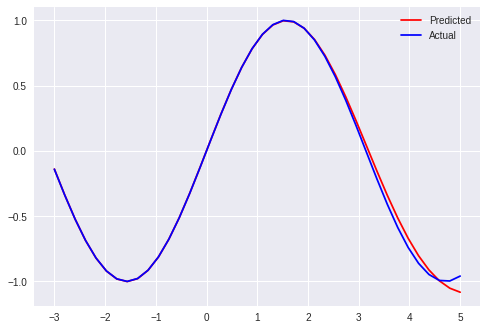

In [101]:
m_n, S_n = posterior_predictive(rbf_kernel, Xs, X, y, kernelParameter, sigma_f)
plt.figure()
plt.plot(Xs.ravel(), m_n.ravel(), '-r', label='Predicted')
tmp_ys = np.sin(Xs)
plt.plot(Xs.ravel(), tmp_ys, '-b', label='Actual')
plt.legend()
plt.show()

In [102]:
kernelParameter, sigma_f

(2.2984389960067766, 0.9266234864974641)